<a href="https://colab.research.google.com/github/lucas6028/machine-learning/blob/main/CNN/sports_balls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sports balls - multiclass image classification

## Donwload the Dataset


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/sports-balls-multiclass-image-classification")

print("Path to dataset files:", path)

100%|██████████| 401M/401M [00:07<00:00, 59.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/versions/2


## Import Packages
First, we need to import packages that will be used later.

In [2]:
# Import necessary packages.
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.multiprocessing as mp
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, random_split
from torchvision.datasets import DatasetFolder
from torchvision.models import resnet50
from glob import glob

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm as notebook_tqdm
from tqdm import tqdm
import sys

if 'google.colab' in sys.modules:
    tqdm = notebook_tqdm

## **Dataset, Data Loader, and Transforms**

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.DatasetFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [4]:
def ensure_three_channels(img):
    # If the image is grayscale, convert it to RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
    return img

# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Lambda(ensure_three_channels),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,1.2), shear=5),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Lambda(ensure_three_channels),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 128

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
tv_set = DatasetFolder(path + "/train", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
train_set, valid_set = random_split(tv_set, [0.8, 0.2])
test_set = DatasetFolder(path + "/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
# unlabeled_set = DatasetFolder("food-11/training/unlabeled"  , loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

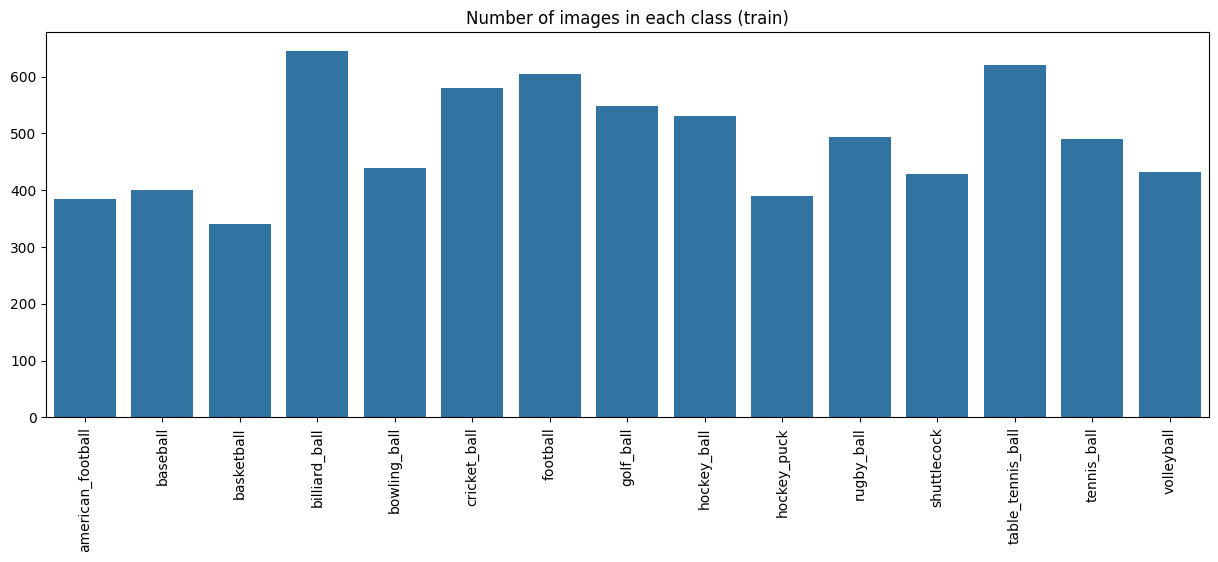

In [6]:
classes = []
num_imgs = []
train_path = path + "/train"
train_folders = sorted(glob(train_path + '/*'))
for path in train_folders:
    class_name = path.split('/')[-1]
    classes.append(class_name)

    num = len(glob(path+'/*'))
    num_imgs.append(num)

plt.figure(figsize=(15,5))
sns.barplot(x=classes, y=num_imgs)
plt.title('Number of images in each class (train)')
plt.xticks(rotation=90)
plt.show()

In [7]:
classes

['american_football',
 'baseball',
 'basketball',
 'billiard_ball',
 'bowling_ball',
 'cricket_ball',
 'football',
 'golf_ball',
 'hockey_ball',
 'hockey_puck',
 'rugby_ball',
 'shuttlecock',
 'table_tennis_ball',
 'tennis_ball',
 'volleyball']

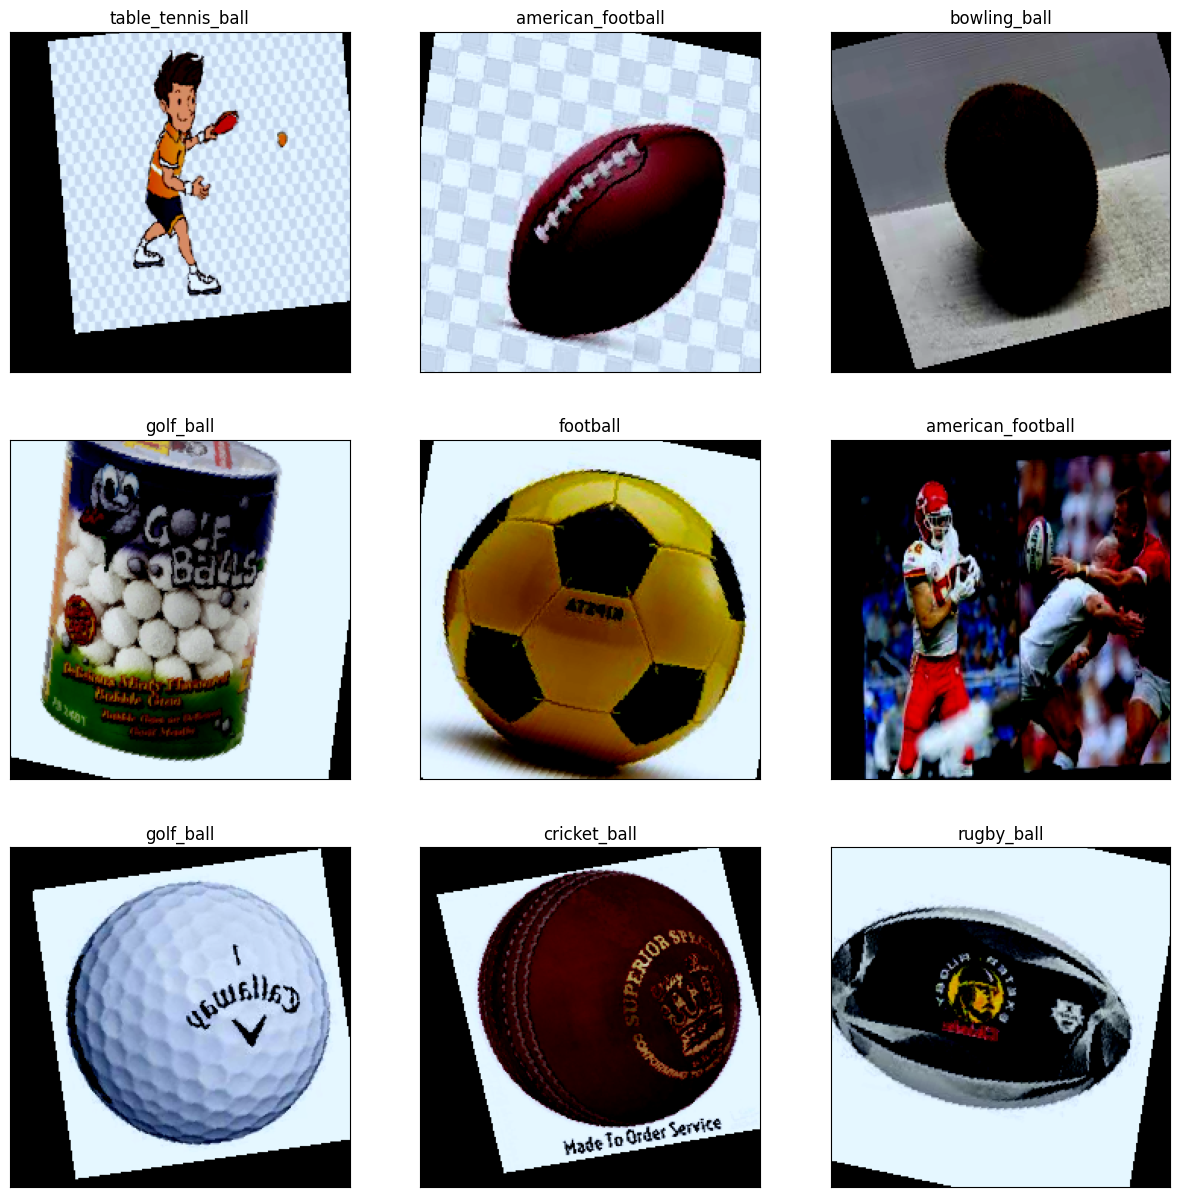

In [8]:
plot_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = next(iter(plot_loader))
    label = int(batch[1].numpy()[0])
    image = np.transpose(batch[0][0].numpy(), (1, 2, 0))/2.5
    plt.imshow(image)
    plt.title(classes[label])
plt.show()

## Utilites

In [9]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
  ''' Plot learning curve of your DNN (train & dev loss) '''
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
  plt.ylim(0.0, 5.)
  plt.xlabel('Training steps')
  plt.ylabel('MSE loss')
  plt.title('Learning curve of {}'.format(title))
  plt.legend()
  plt.show()

# Plot history
def plot_hist(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss_hist, label='Train_Loss')
    plt.plot(test_loss_hist, label='Test_loss')
    plt.title('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_hist, label='Train_Accuracy')
    plt.plot(test_acc_hist, label='Val_Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

## **Model**

The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

### **WARNING -- You Must Know**
You are free to modify the model architecture here for further improvement.
However, if you want to use some well-known architectures such as ResNet50, please make sure **NOT** to load the pre-trained weights.
Using such pre-trained models is considered cheating and therefore you will be punished.
Similarly, it is your responsibility to make sure no pre-trained weights are used if you use **torch.hub** to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=**False**) → This is fine.

model = torchvision.models.resnet18(pretrained=**True**)  → This is **NOT** allowed.

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 128, 128]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 15)
        )

    def forward(self, x):
        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

## **Training**

You can finish supervised learning by simply running the provided code without any modification.

The function "get_pseudo_labels" is used for semi-supervised learning.
It is expected to get better performance if you use unlabeled data for semi-supervised learning.
However, you have to implement the function on your own and need to adjust several hyperparameters manually.

For more details about semi-supervised learning, please refer to [Prof. Lee's slides](https://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/semi%20(v3).pdf).

Again, please notice that utilizing external data (or pre-trained model) for training is **prohibited**.

In [11]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(data_loader, leave=True):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # ---------- TODO ----------
        # Filter the data and construct a new dataset.

    # # Turn off the eval mode.
    model.train()
    return dataset

In [12]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 40

# Whether to do semi-supervised learning.
do_semi = False

# Initialize lists for plotting
train_loss_hist = []
train_acc_hist = []
valid_loss_hist = []
valid_acc_hist = []


for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi:
        # Obtain pseudo-labels for unlabeled data using trained model.
        pseudo_set = get_pseudo_labels(unlabeled_set, model)

        # Construct a new dataset and a data loader for training.
        # This is used in semi-supervised learning only.
        concat_dataset = ConcatDataset([train_set, pseudo_set])
        train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Append to historical lists
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Append to historical lists
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 001/040 ] loss = 2.75516, acc = 0.16979


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 001/040 ] loss = 2.44632, acc = 0.22310


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 002/040 ] loss = 2.22365, acc = 0.29200


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 002/040 ] loss = 2.23014, acc = 0.30217


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 003/040 ] loss = 2.07096, acc = 0.34447


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 003/040 ] loss = 2.12823, acc = 0.33181


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 004/040 ] loss = 1.96543, acc = 0.37692


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 004/040 ] loss = 2.09823, acc = 0.34502


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 005/040 ] loss = 1.89681, acc = 0.39537


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 005/040 ] loss = 2.06986, acc = 0.34352


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 006/040 ] loss = 1.83500, acc = 0.40990


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 006/040 ] loss = 2.00113, acc = 0.37640


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 007/040 ] loss = 1.74178, acc = 0.44718


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 007/040 ] loss = 2.00767, acc = 0.37122


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 008/040 ] loss = 1.69651, acc = 0.45994


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 008/040 ] loss = 1.93054, acc = 0.39155


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 009/040 ] loss = 1.65507, acc = 0.47357


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 009/040 ] loss = 1.92111, acc = 0.39445


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 010/040 ] loss = 1.60305, acc = 0.48660


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 010/040 ] loss = 1.91301, acc = 0.41383


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 011/040 ] loss = 1.55530, acc = 0.49738


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 011/040 ] loss = 1.85186, acc = 0.42572


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 012/040 ] loss = 1.49682, acc = 0.52503


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 012/040 ] loss = 1.86183, acc = 0.44280


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 013/040 ] loss = 1.47725, acc = 0.52655


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 013/040 ] loss = 1.84820, acc = 0.43286


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 014/040 ] loss = 1.43079, acc = 0.54056


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 014/040 ] loss = 1.88510, acc = 0.44460


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 015/040 ] loss = 1.39473, acc = 0.55275


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 015/040 ] loss = 1.80759, acc = 0.43287


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 016/040 ] loss = 1.37044, acc = 0.56047


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 016/040 ] loss = 1.76849, acc = 0.46704


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 017/040 ] loss = 1.33313, acc = 0.56837


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 017/040 ] loss = 1.78661, acc = 0.47519


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 018/040 ] loss = 1.29084, acc = 0.58459


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 018/040 ] loss = 1.71275, acc = 0.49114


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 019/040 ] loss = 1.26914, acc = 0.59062


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 019/040 ] loss = 1.84624, acc = 0.46640


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 020/040 ] loss = 1.24185, acc = 0.60289


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 020/040 ] loss = 1.77531, acc = 0.46135


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 021/040 ] loss = 1.21053, acc = 0.60717


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 021/040 ] loss = 1.79294, acc = 0.47276


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 022/040 ] loss = 1.18731, acc = 0.61528


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 022/040 ] loss = 1.74879, acc = 0.48121


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 023/040 ] loss = 1.15352, acc = 0.63159


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 023/040 ] loss = 1.71849, acc = 0.49405


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 024/040 ] loss = 1.13775, acc = 0.63328


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 024/040 ] loss = 1.72915, acc = 0.48461


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 025/040 ] loss = 1.09515, acc = 0.64615


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 025/040 ] loss = 1.76625, acc = 0.49211


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 026/040 ] loss = 1.06840, acc = 0.65969


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 026/040 ] loss = 1.72870, acc = 0.52270


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 027/040 ] loss = 1.06545, acc = 0.65094


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 027/040 ] loss = 1.73021, acc = 0.48999


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 028/040 ] loss = 1.01776, acc = 0.66877


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 028/040 ] loss = 1.67381, acc = 0.52937


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 029/040 ] loss = 1.02114, acc = 0.66694


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 029/040 ] loss = 1.74719, acc = 0.52025


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 030/040 ] loss = 0.96060, acc = 0.69156


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 030/040 ] loss = 1.78461, acc = 0.49861


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 031/040 ] loss = 0.95580, acc = 0.69395


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 031/040 ] loss = 1.76715, acc = 0.49650


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 032/040 ] loss = 0.96619, acc = 0.68346


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 032/040 ] loss = 1.75139, acc = 0.50202


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 033/040 ] loss = 0.87912, acc = 0.71055


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 033/040 ] loss = 1.75905, acc = 0.50056


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 034/040 ] loss = 0.89818, acc = 0.70435


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 034/040 ] loss = 1.79804, acc = 0.48318


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 035/040 ] loss = 0.88069, acc = 0.71072


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 035/040 ] loss = 1.72652, acc = 0.52155


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 036/040 ] loss = 0.86061, acc = 0.71348


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 036/040 ] loss = 1.79211, acc = 0.51310


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 037/040 ] loss = 0.84747, acc = 0.71916


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 037/040 ] loss = 1.74678, acc = 0.51473


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 038/040 ] loss = 0.81772, acc = 0.72808


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 038/040 ] loss = 1.83713, acc = 0.51326


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 039/040 ] loss = 0.82355, acc = 0.72923


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 039/040 ] loss = 1.71469, acc = 0.52108


  0%|          | 0/46 [00:00<?, ?it/s]

[ Train | 040/040 ] loss = 0.79419, acc = 0.73785


  0%|          | 0/12 [00:00<?, ?it/s]

[ Valid | 040/040 ] loss = 1.80217, acc = 0.52400


## Evaluate the Model
Once trained, evaluate the model on a test set or use it for predictions.

In [13]:
# Evaluate on test set
model.eval()  # Set the model to evaluation mode.

test_acc = []  # To record accuracy.

# Iterate through the test dataloader.
for batch in tqdm(test_loader, leave=True):

    # A batch consists of image data and corresponding labels.
    imgs, labels = batch

    # Use no_grad() to save memory and computational cost during inference.
    with torch.no_grad():
        logits = model(imgs.to(device))  # Forward pass.

    # Compute accuracy.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
    test_acc.append(acc)

# Calculate average test accuracy.
test_acc = sum(test_acc) / len(test_acc)
print(f"[ Test | accuracy = {test_acc:.5f} ]")

  0%|          | 0/15 [00:00<?, ?it/s]

[ Test | accuracy = 0.56494 ]


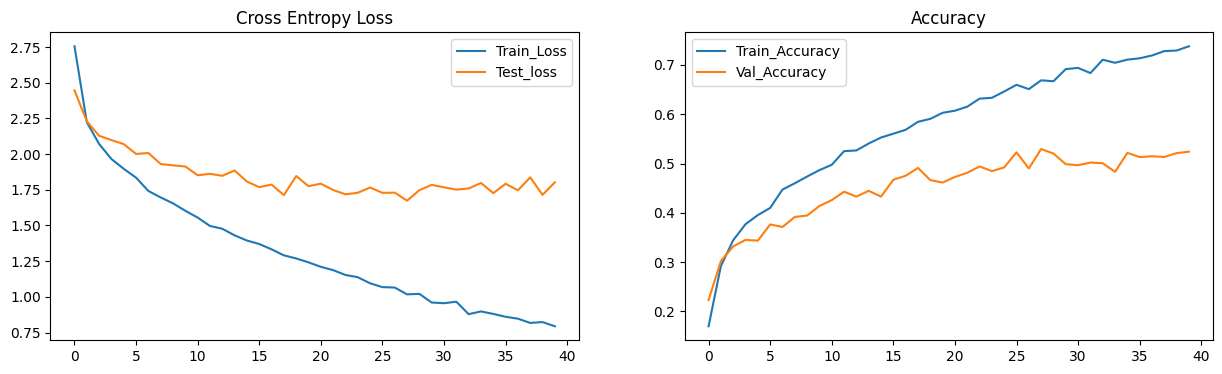

In [15]:
train_acc_hist = [acc.cpu().numpy() for acc in train_acc_hist]
valid_acc_hist = [acc.cpu().numpy() for acc in valid_acc_hist]
plot_hist(train_loss_hist, valid_loss_hist, train_acc_hist, valid_acc_hist)

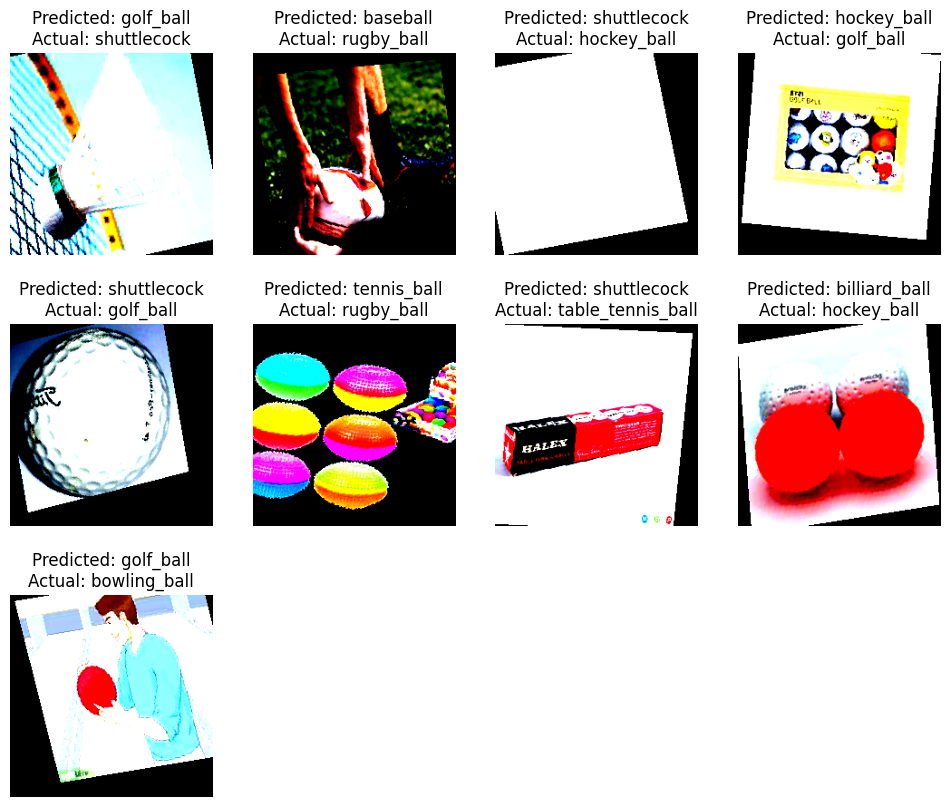

In [16]:
# Access class names
class_names = tv_set.classes  # Maps indices to folder names (e.g., 0 -> 'apple', 1 -> 'banana')

# Create a DataLoader
test_loader = DataLoader(tv_set, batch_size=32, shuffle=True)

# Visualize incorrect predictions
model.eval()  # Ensure the model is in evaluation mode.

# Get a batch from the test loader
data_iter = iter(test_loader)
imgs, labels = next(data_iter)

# Move the images and labels to the same device as the model
imgs, labels = imgs.to(device), labels.to(device)

# Perform predictions
with torch.no_grad():
    logits = model(imgs)

# Convert logits to predicted class indices
preds = logits.argmax(dim=-1)

# Find incorrect predictions
incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

# Check if there are any incorrect predictions
if len(incorrect_indices) > 0:
    plt.figure(figsize=(12, 17))  # Adjust figure size to fit multiple subplots

    for i, idx in enumerate(incorrect_indices[:20]):  # Display up to 20 incorrect predictions
        plt.subplot(5, 4, i + 1)  # Create a grid of 5 rows and 4 columns
        img = imgs[idx].cpu().permute(1, 2, 0)  # Convert CHW to HWC
        plt.imshow(img)
        actual_class = labels[idx].item()
        predicted_class = preds[idx].item()
        actual_label = class_names[actual_class]  # Map number to real label
        predicted_label = class_names[predicted_class]  # Map number to real label
        plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}")
        plt.axis('off')

    plt.show()
else:
    print("No incorrect predictions in this batch.")